# <font size=6 color='green'><center>**Static Architecture**</center></font>
### **<center>Part 1<br/>**

This file contains the code to train the static network architecture to learn the modality specific weights. The network trained here consists of two inputs (face, voice) and one output label where label = 1 if face and voice are of same person, else label is 0

In [1]:
# importing required libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Loading the data using tensorflow data generators for efficient memory usage

In [31]:
# function that parses the tf record
def parser(tfRecord):
   keys_to_features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "audio_raw": tf.io.FixedLenFeature([], tf.string),
        "label":     tf.io.FixedLenFeature([], tf.int64)
    }
   
   parsed = tf.io.parse_single_example(tfRecord, keys_to_features)
   image = tf.io.parse_tensor(parsed['image_raw'], out_type=tf.float64)
   audio = tf.io.parse_tensor(parsed['audio_raw'], out_type=tf.double)
   audio = tf.expand_dims(audio,axis=2)
   label = tf.cast(parsed['label'], tf.int32)
   label = tf.one_hot(label,2)
   return {'faceInput':image,'voiceInput':audio}, label
 
# function to load dataset from the tfrecords file
def get_data_from_records(filenames):
  dataset = tf.data.TFRecordDataset(filenames=filenames, num_parallel_reads=40)
  dataset = dataset.map(parser, num_parallel_calls=12)
  dataset = dataset.batch(batch_size=32)
  dataset = dataset.prefetch(buffer_size=2)
  return dataset

In [32]:
# change this path to the path file containing tensorflow records
inputDataPathTrain = '/kaggle/input/tf-records-for-data/train.tfrecords'
trainDataset = get_data_from_records(inputDataPathTrain)
inputDataPathVal = '/sfdf'
valDataset = get_data_from_records(inputDataPathVal)

In [ ]:
import sys
sys.path.append('../')

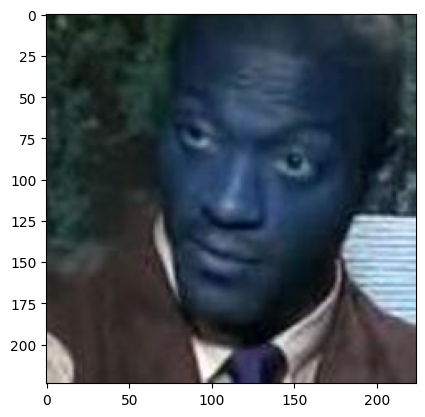

Shape of the mfcc co-efficients: (20, 130, 1)


In [33]:
# show a sample images and mfccs
X_data, labels = next(iter(trainDataset))

# plotting the image input
plt.imshow(X_data['faceInput'][0])
plt.show()

mfcc=X_data['voiceInput'][0]
print(f"Shape of the mfcc co-efficients: {mfcc.shape}")

Defining the neural network models

In [2]:
# Building a face subnetwork
w_decay = 0.001

# def FaceSubnet():
faceInput = keras.layers.Input(shape=(224,224,3),name='faceInput')

flayer1 = keras.layers.Conv2D(filters=96, kernel_size=(7,7), strides=(2,2), padding="same", activation="relu", name='flayer1i')

fout1 = keras.layers.MaxPool2D(pool_size=(2,2),padding="valid",name="flayer1o")(flayer1(faceInput))

flayer2 = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding="same", activation="relu",name='flayer2i')

fout2 = keras.layers.MaxPool2D(pool_size=(2,2), padding="valid",name='flayer2o')(flayer2(fout1))

flayer3 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),padding="same", activation="relu",name='flayer3i')

fout3 = keras.layers.MaxPool2D(pool_size=(2,2), padding="valid",name='flayer3o')(flayer3(flayer3(flayer3(fout2))))

flayer4 = keras.layers.Dense(units=4096, activation='relu',name='flayer4i')

fout4 = keras.layers.Flatten(name='flayer40')(flayer4(fout3))

flayer5 = keras.layers.Dense(units=1024, activation='relu',name='flayer5i')

faceFeatures = flayer5(fout4)
    

# def VoiceSubnet():

voiceInput = keras.layers.Input(shape=(20,130,1),name='voiceInput')

vlayer1 = keras.layers.Conv2D(filters=96, kernel_size=(7,7), strides=(2,2), padding="same", activation="relu",name='vlayer1i')

vout1 = keras.layers.MaxPool2D(pool_size=(2,2),padding="valid",name='vlayer1o')(vlayer1(voiceInput))

vlayer2 = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding="same", activation="relu",name='vlayer2i')

vout2 = keras.layers.MaxPool2D(pool_size=(2,2), padding="valid",name='vlayer2o')(vlayer2(vout1))

vlayer3 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),padding="same", activation="relu",name='vlayer3i')

vout3 = keras.layers.MaxPool2D(pool_size=(1,2), padding="valid",name='vlayer3o')(vlayer3(vlayer3(vlayer3(vout2))))

vlayer4 = keras.layers.Dense(units=4096, activation='relu',name='vlayer4i')

vout4 = keras.layers.Flatten(name='valyer4o')(vlayer4(vout3))

vlayer5 = keras.layers.Dense(units=1024, activation='relu',name='vlayer5i')

voiceFeatures = vlayer5(vout4)

In [3]:
combinedInputs = keras.layers.concatenate([faceFeatures, voiceFeatures])

clayer1 = keras.layers.Dense(1024, activation='relu',name='mlayer1')

clayer2 = keras.layers.Dense(512, activation='relu',name='mlayer2')

clayer3 = keras.layers.Dense(2, activation='relu',name='mlayer3')

finalOutput = clayer3(clayer2(clayer1(combinedInputs)))

In [4]:
model = keras.Model(
    inputs=[faceInput, voiceInput],
    outputs = finalOutput
)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 faceInput (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 voiceInput (InputLayer)        [(None, 20, 130, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 flayer1i (Conv2D)              (None, 112, 112, 96  14208       ['faceInput[0][0]']              
                                )                                                             

The architecture of model looks like this

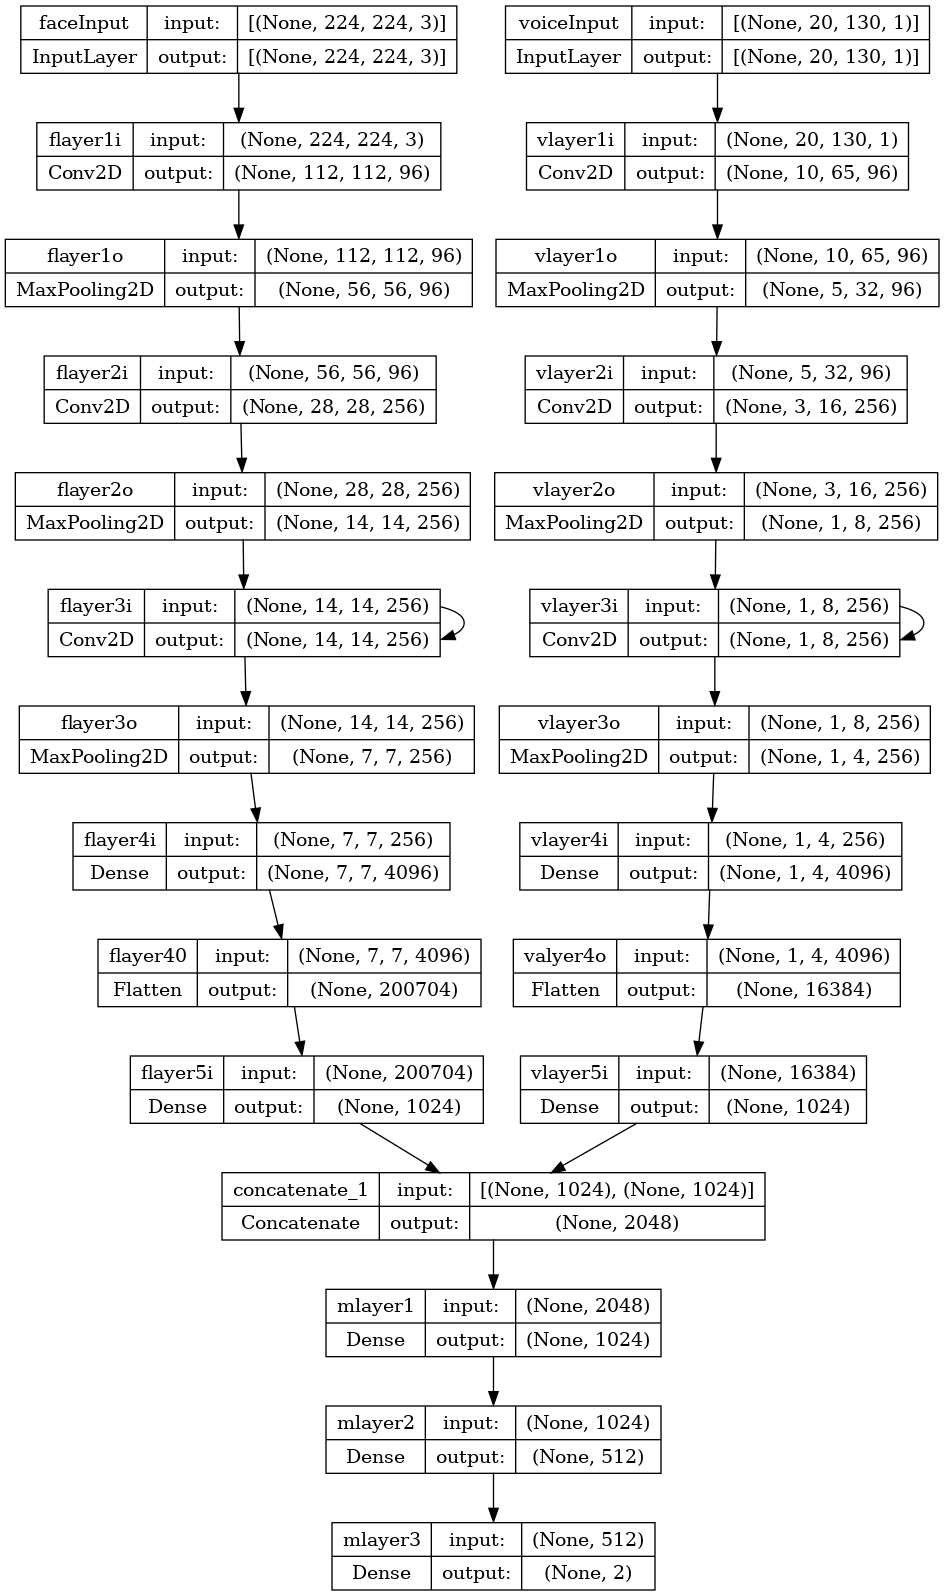

In [38]:
keras.utils.plot_model(model, show_shapes=True)

In [39]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [43]:
history = model.fit(trainDataset,epochs = 50, validation_data=valDataset)

Epoch 1/5
47/47 [==============================] - 6s 103ms/step - loss: 5.3727 - accuracy: 0.6667
Epoch 2/5
47/47 [==============================] - 5s 101ms/step - loss: 5.3727 - accuracy: 0.6667
Epoch 3/5
47/47 [==============================] - 5s 101ms/step - loss: 5.3727 - accuracy: 0.6667
Epoch 4/5
47/47 [==============================] - 5s 101ms/step - loss: 5.3727 - accuracy: 0.6667
Epoch 5/5
47/47 [==============================] - 5s 101ms/step - loss: 5.3727 - accuracy: 0.6667


In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

fig.set_size_inches(18.5, 10.5)

# Plot loss
ax1.set_title('Loss')
ax1.plot(history.history['loss'], label = 'train')
ax1.plot(history.history['val_loss'], label = 'test')
ax1.set_ylabel('Loss')

# Determine upper bound of y-axis
max_loss = max(history.history['loss'] + history.history['val_loss'])

ax1.set_ylim([0, np.ceil(max_loss)])
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation']) 

# Plot accuracy
ax2.set_title('Accuracy')
ax2.plot(history.history['accuracy'],  label = 'train')
ax2.plot(history.history['val_accuracy'], label = 'test')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

saving the learned model weights

In [ ]:
model.save_weights('staticModel1.h5')

---